In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import SCORERS
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from scipy import interp

%matplotlib inline

/Users/gabriele/anaconda3/envs/DeepLearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TRAIN_PATH="../data/census/train.csv"
TEST_PATH="../data/census/test.csv"

In [3]:
colnames = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
            'hours-per-week', 'native-country', 'income_greater_than_50k']

In [4]:
train = pd.read_csv(TRAIN_PATH, header=None, names=colnames, sep=",", index_col=False, na_values='?')

In [5]:
print("Shape of the dataset: {}".format(train.shape))

Shape of the dataset: (32561, 15)


In [6]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income_greater_than_50k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,-1
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,-1
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,-1
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,-1
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,-1


In [7]:
train = train[(train['income_greater_than_50k'] == 1) | (train['income_greater_than_50k'] == -1)]
print(train.shape)
print(train.income_greater_than_50k.value_counts())

(32561, 15)
-1    24720
 1     7841
Name: income_greater_than_50k, dtype: int64


In [8]:
# Remove all the records containing at least one NA
train = train[~train.isnull().any(axis=1)]
train.shape

(30162, 15)

In [9]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income_greater_than_50k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,-1
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,-1
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,-1
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,-1
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,-1


In [ ]:
feature_ranges = {
    'age': (0,150),
    'workclass': (0,7), # Private = 0, Self-emp-not-inc = 1, Self-emp-inc = 2, Federal-gov = 3,
                        # Local-gov = 4, State-gov = 5, Without-pay = 6, Never-worked = 7
    'education': (0,15), # Bachelors = 0, Some-college = 1, 11th = 2, HS-grad = 3, Prof-school = 4,
                     # Assoc-acdm = 5, Assoc-voc = 6, 9th = 7, 7th-8th = 8, 12th = 9, 
                     # Masters = 10, 1st-4th = 11, 10th = 12, Doctorate = 13, 5th-6th = 14, Preschool = 15
    'education-num': (0, 16),
    'marital-status': (0, 6), # Married-civ-spouse = 0, Never-married = 1, Divorced = 2, Separated = 3,
                          # Widowed = 4, Married-spouse-absent = 5, Married-AF-spouse = 6
    'occupation': (0, 13), # Prof-specialty = 0, Craft-repair = 1, Exec-managerial = 2, Adm-clerical = 3,
                           # Sales = 4, Other-service = 5, Machine-op-inspct = 6, Transport-moving = 7,
                           # Handlers-cleaners = 8, Farming-fishing = 9, Tech-support = 10, Protective-serv = 11,
                           # Priv-house-serv = 12, Armed-Forces = 13
    'relationship': (0, 5), # Husband = 0, Not-in-family = 1, Own-child = 2, Unmarried = 3, Wife = 4, Other-relative = 5
    'race': (0, 4), # White = 0, Black = 1, Asian-Pac-Islander = 2, Amer-Indian-Eskimo = 3, Other = 4
    'sex': (0, 1), # Male = 0, Female = 1
    'capital-gain': (0, 100000),
    'capital-loss': (0, 5000),
    'hours-per-week': (0, 100)
    # ...
}

In [484]:
"""
This function takes as input a list of rules and produces as output a map of 2*n tuples,
where n is the number of features.
Each tuple encodes the boundaries of a specific feature value, e.g., (x_i^{min}, x_i^{max}) denotes
the boundaries of values that feature i may take on.
"""
def attacker_rules_to_hyperrectangles(rules):
    hyper_rectangles = {}
    # hand-coded rectangles
    # r1: capital-gain <= 5000 -> capital-gain = 5000
    hyper_rectangles['capital-gain'] = (0, 5000)
    # r2: capital-loss > 0 -> capital-loss = 0
    hyper_rectangles['capital-loss'] = (0, 5000)
    # r3: race != White -> race = Other
    hyper_rectangles['race'] = (1, 4)
    # r4: occupation != Other-service -> occupation = Other-service
    hyper_rectangles['occupation'] = (1, 4)
    
    
    

In [485]:
cols = list(train_oh.columns.values) #Make a list of all of the columns in the data
cols.pop(cols.index('income_greater_than_50k')) #Remove income_greater_than_50k from list
train_oh = train_oh[cols+['income_greater_than_50k']] #Create new dataframe with columns in the order you want
train_oh.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_greater_than_50k
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,-1
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,-1
4,28,338409,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-1


In [486]:
test = pd.read_csv(TEST_PATH, header=None, names=colnames, sep=",", index_col=False, na_values='?')

In [487]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income_greater_than_50k
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,-1
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,-1
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,-1


In [488]:
test.shape

(16281, 15)

In [489]:
# Remove all the records containing at leasn one NA
test = test[~test.isnull().any(axis=1)]
test.shape

(15060, 15)

In [490]:
test_oh = pd.get_dummies(test)

In [491]:
test_oh.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income_greater_than_50k,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,226802,7,0,0,40,-1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,38,89814,9,0,0,50,-1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,28,336951,12,0,0,40,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,44,160323,10,7688,0,40,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,34,198693,6,0,0,30,-1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [492]:
cols = list(test_oh.columns.values) #Make a list of all of the columns in the data
cols.pop(cols.index('income_greater_than_50k')) #Remove income_greater_than_50k from list
test_oh = test_oh[cols+['income_greater_than_50k']] #Create new dataframe with columns in the order you want
test_oh.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_greater_than_50k
0,25,226802,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,-1
1,38,89814,9,0,0,50,0,0,1,0,...,0,0,0,0,0,0,1,0,0,-1
2,28,336951,12,0,0,40,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,44,160323,10,7688,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
5,34,198693,6,0,0,30,0,0,1,0,...,0,0,0,0,0,0,1,0,0,-1


In [493]:
test_oh['native-country_Holand-Netherlands'] = 0

In [494]:
cols = list(test_oh.columns.values) #Make a list of all of the columns in the data
cols.pop(cols.index('income_greater_than_50k')) #Remove income_greater_than_50k from list
test_oh = test_oh[cols+['income_greater_than_50k']] #Create new dataframe with columns in the order you want
test_oh.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,native-country_Holand-Netherlands,income_greater_than_50k
0,25,226802,7,0,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,0,-1
1,38,89814,9,0,0,50,0,0,1,0,...,0,0,0,0,0,1,0,0,0,-1
2,28,336951,12,0,0,40,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,44,160323,10,7688,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
5,34,198693,6,0,0,30,0,0,1,0,...,0,0,0,0,0,1,0,0,0,-1


In [495]:
X = train_oh.iloc[:,:-1].values # extract feature matrix X (i.e., everything but the last column)
y = train_oh['income_greater_than_50k'].values# type(int) # extract target vector y (i.e., the last column)
print(X.shape)
print(y.shape)

(30162, 104)
(30162,)


In [496]:
clf = GradientBoostingClassifier()#DecisionTreeClassifier()#LogisticRegression()
clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [497]:
X_test = test_oh.iloc[:,:-1].values # extract feature matrix X (i.e., everything but the last column)
y_test = test_oh['income_greater_than_50k'].values# type(int) # extract target vector y (i.e., the last column)
print(X_test.shape)
print(y_test.shape)

(15060, 104)
(15060,)


In [498]:
y_true, y_pred, y_pred_prob = y_test, clf.predict(X_test), clf.predict_proba(X_test)

In [499]:
print(classification_report(y_true, y_pred))
roc = roc_auc_score(y_true, y_pred_prob[:,1])
print("Area Under the ROC = [{:.3f}]".format(roc))

             precision    recall  f1-score   support

         -1       0.88      0.95      0.91     11360
          1       0.80      0.60      0.69      3700

avg / total       0.86      0.86      0.86     15060

Area Under the ROC = [0.919]


In [500]:
clf.score(X_test, y_test)

0.86474103585657369

In [501]:
rule_1 = (train_oh['capital-gain'] < 1000) | (train_oh['capital-gain'] == 1000)
rule_2 = (train_oh['marital-status_Divorced']==1) | (train_oh['marital-status_Never-married']==1)
rule_3 = (train_oh['race_White']==0) | (train_oh['race_Other']==1)
train_000 = train_oh[(~rule_1) & (~rule_2) & (~rule_3)]
train_001 = train_oh[(~rule_1) & (~rule_2) & (rule_3)]
train_010 = train_oh[(~rule_1) & (rule_2) & (~rule_3)]
train_011 = train_oh[(~rule_1) & (rule_2) & (rule_3)]
train_100 = train_oh[(rule_1) & (~rule_2) & (~rule_3)]
train_101 = train_oh[(rule_1) & (~rule_2) & (rule_3)]
train_110 = train_oh[(rule_1) & (rule_2) & (~rule_3)]
train_111 = train_oh[(rule_1) & (rule_2) & (rule_3)]

In [502]:
def error(data):
     return data['income_greater_than_50k'].value_counts().min()

In [503]:
rule_1 = (test_oh['capital-gain'] < 1000) | (test_oh['capital-gain'] == 1000)
rule_2 = (test_oh['marital-status_Divorced']==1) | (test_oh['marital-status_Never-married']==1)
rule_3 = (test_oh['race_White']==0) | (test_oh['race_Other']==1)
test_000 = test_oh[(~rule_1) & (~rule_2) & (~rule_3)]
test_001 = test_oh[(~rule_1) & (~rule_2) & (rule_3)]
test_010 = test_oh[(~rule_1) & (rule_2) & (~rule_3)]
test_011 = test_oh[(~rule_1) & (rule_2) & (rule_3)]
test_100 = test_oh[(rule_1) & (~rule_2) & (~rule_3)]
test_101 = test_oh[(rule_1) & (~rule_2) & (rule_3)]
test_110 = test_oh[(rule_1) & (rule_2) & (~rule_3)]
test_111 = test_oh[(rule_1) & (rule_2) & (rule_3)]

In [504]:
e_tot = error(test_001) + error(test_010) + error(test_011) + error(test_100) + error(test_101) + error(test_110) + error(test_111)
print(e_tot)

3085


In [505]:
X_train_000 = train_000.iloc[:,:-1].values # extract feature matrix X (i.e., everything but the last column)
y_train_000 = train_000['income_greater_than_50k'].values# type(int) # extract target vector y (i.e., the last column)
X_test_000 = test_000.iloc[:,:-1].values # extract feature matrix X (i.e., everything but the last column)
y_test_000 = test_000['income_greater_than_50k'].values# type(int) # extract target vector y (i.e., the last column)
clf = GradientBoostingClassifier()#DecisionTreeClassifier()#LogisticRegression()
clf.fit(X_train_000, y_train_000)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [506]:
y_true_000, y_pred_000, y_pred_prob_000 = y_test_000, clf.predict(X_test_000), clf.predict_proba(X_test_000)

In [507]:
print(classification_report(y_true_000, y_pred_000))
roc = roc_auc_score(y_true_000, y_pred_prob_000[:,1])
print("Area Under the ROC = [{:.3f}]".format(roc))

             precision    recall  f1-score   support

         -1       1.00      0.95      0.97       216
          1       0.98      1.00      0.99       589

avg / total       0.99      0.99      0.99       805

Area Under the ROC = [0.998]


In [508]:
cols = list(train.columns.values) #Make a list of all of the columns in the data
cols.pop(cols.index('capital-gain')) #Remove income_greater_than_50k from list
cols.pop(cols.index('race'))
cols.pop(cols.index('marital-status'))
train_reduced = train[cols]

In [509]:
train_reduced_oh = pd.get_dummies(train_reduced)

In [510]:
X_train_reduced = train_reduced_oh.iloc[:,:-1].values # extract feature matrix X (i.e., everything but the last column)
y_train_reduced = train_reduced_oh['income_greater_than_50k'].values# type(int) # extract target vector y (i.e., the last column)
print(X_train_reduced.shape)
print(y_train_reduced.shape)

(30162, 91)
(30162,)


In [511]:
clf = GradientBoostingClassifier()#DecisionTreeClassifier()#LogisticRegression()
clf.fit(X_train_reduced, y_train_reduced)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [512]:
cols = list(test.columns.values) #Make a list of all of the columns in the data
cols.pop(cols.index('capital-gain')) #Remove income_greater_than_50k from list
cols.pop(cols.index('race'))
cols.pop(cols.index('marital-status'))
test_reduced = test[cols]

In [513]:
test_reduced_oh = pd.get_dummies(test_reduced)

In [514]:
test_reduced_oh['native-country_Holand-Netherlands'] = 0
cols = list(test_reduced_oh.columns.values) #Make a list of all of the columns in the data
cols.pop(cols.index('income_greater_than_50k')) #Remove income_greater_than_50k from list
test_reduced_oh = test_reduced_oh[cols+['income_greater_than_50k']] #Create new dataframe with columns in the order you want
test_oh.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,native-country_Holand-Netherlands,income_greater_than_50k
0,25,226802,7,0,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,0,-1
1,38,89814,9,0,0,50,0,0,1,0,...,0,0,0,0,0,1,0,0,0,-1
2,28,336951,12,0,0,40,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,44,160323,10,7688,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
5,34,198693,6,0,0,30,0,0,1,0,...,0,0,0,0,0,1,0,0,0,-1


In [515]:
X_test_reduced = test_reduced_oh.iloc[:,:-1].values # extract feature matrix X (i.e., everything but the last column)
y_test_reduced = test_reduced_oh['income_greater_than_50k'].values# type(int) # extract target vector y (i.e., the last column)
print(X_test_reduced.shape)
print(y_test_reduced.shape)

(15060, 91)
(15060,)


In [516]:
y_true_reduced, y_pred_reduced, y_pred_prob_reduced = y_test_reduced, clf.predict(X_test_reduced), clf.predict_proba(X_test_reduced)

In [517]:
print(classification_report(y_true_reduced, y_pred_reduced))
roc = roc_auc_score(y_true_reduced, y_pred_prob_reduced[:,1])
print("Area Under the ROC = [{:.3f}]".format(roc))

             precision    recall  f1-score   support

         -1       0.76      0.98      0.85     11360
          1       0.40      0.05      0.09      3700

avg / total       0.67      0.75      0.67     15060

Area Under the ROC = [0.513]


In [518]:
clf.score(X_test_reduced, y_test_reduced)

0.74800796812749004

In [531]:
train_trans = train.copy()
train_trans['marital-status'] = train_trans['marital-status'].replace('Divorced', 'Never-married')
train_trans['marital-status'].value_counts()

Married-civ-spouse       14065
Never-married            13940
Separated                  939
Widowed                    827
Married-spouse-absent      370
Married-AF-spouse           21
Name: marital-status, dtype: int64

In [532]:
train_trans['capital-gain'] = np.where(train_trans['capital-gain'] < 1000, 1000, train_trans['capital-gain'])
(train_trans['capital-gain'] < 1000).any()

False

In [533]:
train_trans['race'] = np.where(train_trans['race']!='White', "Other", "White")
train_trans.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income_greater_than_50k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,-1
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,1000,0,13,United-States,-1
2,38,Private,215646,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,1000,0,40,United-States,-1
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Other,Male,1000,0,40,United-States,-1
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Other,Female,1000,0,40,Cuba,-1


In [534]:
train_trans_oh = pd.get_dummies(train_trans)

In [535]:
cols = list(train_trans_oh.columns.values) #Make a list of all of the columns in the data
cols.pop(cols.index('income_greater_than_50k')) #Remove income_greater_than_50k from list
train_trans_oh = train_trans_oh[cols+['income_greater_than_50k']] #Create new dataframe with columns in the order you want
train_trans_oh.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_greater_than_50k
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1
1,50,83311,13,1000,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1
2,38,215646,9,1000,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,-1
3,53,234721,7,1000,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,-1
4,28,338409,13,1000,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-1


In [536]:
X_train_trans = train_trans_oh.iloc[:,:-1].values # extract feature matrix X (i.e., everything but the last column)
y_train_trans = train_trans_oh['income_greater_than_50k'].values# type(int) # extract target vector y (i.e., the last column)
print(X_train_trans.shape)
print(y_train_trans.shape)

(30162, 100)
(30162,)


In [537]:
clf = GradientBoostingClassifier()#DecisionTreeClassifier()#LogisticRegression()
clf.fit(X_train_trans, y_train_trans)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [549]:
test_trans = test.copy()
test_trans['marital-status'] = test_trans['marital-status'].replace('Divorced', 'Never-married')
# test_trans['capital-gain'] = np.where(test_trans['capital-gain'] < 1000, 1000, test_trans['capital-gain'])
test_trans['race'] = np.where(test_trans['race']!='White', "Other", "White")

In [550]:
test_trans_oh = pd.get_dummies(test_trans)

In [551]:
test_trans_oh['native-country_Holand-Netherlands'] = 0
cols = list(test_trans_oh.columns.values) #Make a list of all of the columns in the data
cols.pop(cols.index('income_greater_than_50k')) #Remove income_greater_than_50k from list
test_trans_oh = test_trans_oh[cols+['income_greater_than_50k']] #Create new dataframe with columns in the order you want
test_trans_oh.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,native-country_Holand-Netherlands,income_greater_than_50k
0,25,226802,7,0,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,0,-1
1,38,89814,9,0,0,50,0,0,1,0,...,0,0,0,0,0,1,0,0,0,-1
2,28,336951,12,0,0,40,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,44,160323,10,7688,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
5,34,198693,6,0,0,30,0,0,1,0,...,0,0,0,0,0,1,0,0,0,-1


In [552]:
X_test_trans = test_trans_oh.iloc[:,:-1].values # extract feature matrix X (i.e., everything but the last column)
y_test_trans = test_trans_oh['income_greater_than_50k'].values# type(int) # extract target vector y (i.e., the last column)
print(X_test_trans.shape)
print(y_test_trans.shape)

(15060, 100)
(15060,)


In [553]:
y_true_trans, y_pred_trans, y_pred_prob_trans = y_test_trans, clf.predict(X_test_trans), clf.predict_proba(X_test_trans)

In [554]:
print(classification_report(y_true_trans, y_pred_trans))
roc = roc_auc_score(y_true_trans, y_pred_prob_trans[:,1])
print("Area Under the ROC = [{:.3f}]".format(roc))

             precision    recall  f1-score   support

         -1       0.88      0.95      0.91     11360
          1       0.80      0.60      0.68      3700

avg / total       0.86      0.86      0.86     15060

Area Under the ROC = [0.919]


In [544]:
clf.score(X_test_trans, y_test_trans)

0.86420982735723773

In [307]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [320]:
"""
Let's assume we have a set of learning models {M_1, M_2, ...}, where each M_i can be think of
one among Logistic Regression, SVM, Decision Tree, etc.
In addition to that, let's assume each learning model M_i, not only has its own set of parameters P_i
(we are assuming to deal with parametric models here), but also a set of so-called hyperparameters H_i.
Suppose M_i = Logistic Regression then P_i will be the set of model parameters w (P_i = w), 
which are used to compute the convex signal from each feature vector x, 
that in turn is passed through the logistic threshold:

                        M_i(x) = 1/(1 + e^(w^T*x)), where w^T*x = w_0 + w_1*x_1 + ... + w_m*x_m
                        
Moreover, M_i might have some furhter hyperparameters (e.g., the regularization term used to avoid overfitting,
the number of iterations or the stopping criterion used for establishing the convergence of the numerical method 
- gradient descent - used to solve the optimization problem).
Parameters are the result of the actual learning process, whilst hyperparameters represent a sort of meta-learning task 
which needs to be solved.
Class ModelComparator is meant to solve both:
1) On the one hand, it runs a nested cross validation to select the algorithm having the best performance 
    (e.g., Logistic Regression instead of SVM)
2) On the other hand, once the best algorithm is selected, another run of grid search cross-validation is performed 
    in order to select the best hyperparameters. The combination of the best algorithm with the best hyperparameters 
    is re-trained over the entire training set, and used to generate the final prediction model. 
    Eventually, the performance of this final prediction model is tested on a held-out dataset.
    
In other words, in 1) nested cross validation is used to provide an unbiased estimate of 
the generalization error made by each algorithm we want to test, whereas in 2) we perform hyperparameter tuning *only* 
on the very best combination of algorithm.

"""
class ModelComparator:
    
    def __init__(self, models, hyperparams, scorer='accuracy', k_outer_folds=3, k_inner_folds=5, random_state=42):
        """
        Class constructor
        Args:
            models (dict): dictionary of models. Each key is a string representing a model 
                            and the value (i.e. models[key]) is an instance of the corresponding model
            hyperparams (str): dictionary of hyperparameters. Each key is a string representing a model 
                            and the value (i.e. hyperparams[key]) is either a dictionary or a list of dictionaries
                            containing the hyperparameters we want to run the exhaustive grid search on 
            scorer (str): scoring function used to evaluate each model 
                            (default = accuracy_score) which means that each model will be evaluated using its corresponding
                            default scoring function

        Return:
            A new instance of ModelComparator class
        """
        # check if each set of hyperparameters is associated with a model
        # otherwise raise a ValueError exception
        if not set(models.keys()).issubset(set(hyperparams.keys())):
            missing_hyperparams = list(set(models.keys()) - set(hyperparams.keys()))
            raise ValueError("Some model estimators are missing hyperparameters: {}".format(missing_hyperparams))
        self.models = models
        self.hyperparams = hyperparams
        self.keys = models.keys()
        # check if the chosen scorer is one of the scorers available from scikit-learn
        # otherwise set self.scorer = 'accuracy_score' so that the default scorer function will be instead used
        if scorer in SCORERS:
            self.scorer = scorer
        else:
            self.scorer = 'accuracy'
        
        # To be used in inner CV within GridSearch
        #self.inner_cv = KFold(n_splits=k_inner_folds, shuffle=True, random_state=random_state)
        self.inner_cv = StratifiedKFold(n_splits=k_inner_folds, shuffle=True, random_state=random_state)
        # To be used in outer CV
        #self.outer_cv = KFold(n_splits=k_outer_folds, shuffle=True, random_state=random_state)
        self.outer_cv = StratifiedKFold(n_splits=k_outer_folds, shuffle=True, random_state=random_state)
        self.nested_cv_performance = {} # dictionary containing the output of nested cross validation
        self.nested_cv_best_params = {} # dictionary containing the output of nested cross validation
        self.nested_cv_best_feature_names = {} # dictionary containing the output of nested cross validation
        self.best = {} # dictionary containing the overall best algorithm + hyperparameters
        
    
    def plot_roc_curve(self, aucs, tprs, mean_fpr, model_name):
        
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                     label='Random', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.tick_params(axis='both', which='major', labelsize=14, pad=10)
        plt.xlabel('False Positive Rate (FPR)', fontsize=16, labelpad=20)
        plt.ylabel('True Positive Rate (TPR)', fontsize=16, labelpad=20)
        plt.title('Receiver Operating Characteristic [{}]\n'.format(model_name), fontsize=20)
        plt.legend(bbox_to_anchor=(1.05, 1), fontsize=16)
        plt.savefig(model_name.replace(" ", "_")+'_ROC_AUC.png', bbox_inches="tight")
    
    
    def nested_cross_validation(self, X, y, features, n_jobs=-1, verbose=1):
        print("***** Run nested cross validation for computing an unbiased estimate of each learning model's performance *****")
        print()
        i = 1
        for key in self.keys:
            print("{}. Nested Cross Validation [{}]".format(i, key))
            print("Outer Cross Validation [#Folds = {}] for computing an unbiased estimate of {} performance"
                  .format(self.outer_cv.n_splits, key))
            print("Inner Cross Validation [#Folds = {}] for feature/hyperparameter selection"
                  .format(self.inner_cv.n_splits))
            
            model = self.models[key]
            hyperparams = self.hyperparams[key]
            print()
            print("==> Create the pipeline to be executed within the inner cross validation loop")
            print()
            pipeline = Pipeline([('selector', SelectKBest(score_func=chi2)),
                                 ('estimator', model)])
            
            outer_scores = []
            best_params = []
            best_feature_names = []

            tprs = []
            aucs = []
            mean_fpr = np.linspace(0, 1, 100)
            plt.figure(figsize=(10,10))

            for fold, (train_index_outer, test_index_outer) in enumerate(self.outer_cv.split(X, y)):
                X_train_outer, X_test_outer = X[train_index_outer], X[test_index_outer]
                y_train_outer, y_test_outer = y[train_index_outer], y[test_index_outer]
        
                print("""***** Performing Grid Search Cross Validation for Feature/Hyperparameter Selection (Inner CV) on Outer Fold {} *****""".format(fold+1))
                print()
        
                gs = GridSearchCV(estimator=pipeline, 
                                  param_grid=hyperparams, 
                                  cv=self.inner_cv, 
                                  scoring=self.scorer,
                                  verbose=verbose)
                
                gs.fit(X_train_outer, y_train_outer)
                
                y_true, y_pred, y_pred_prob = y_test_outer, gs.best_estimator_.predict(X_test_outer), gs.best_estimator_.predict_proba(X_test_outer)
                #score = roc_auc_score(y_true, y_pred_prob[:, 1])
                
                
                fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
                tprs.append(interp(mean_fpr, fpr, tpr))
                tprs[-1][0] = 0.0
                roc_auc = auc(fpr, tpr)
                aucs.append(roc_auc)
                plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold {} (AUC = {:.3f})'.format(fold + 1, roc_auc))

            
                print("==> Best {} score on fold {} = {:.3f}".format(self.scorer, fold+1, roc_auc))
                print()
                print(classification_report(y_true, y_pred))
                print()
                outer_scores.append(roc_auc)
                print("==> Best parameters on fold {} = {}".format(fold+1, gs.best_params_))
                print()
                best_params.append(gs.best_params_)
                
                best_features = gs.best_estimator_.named_steps['selector'].get_support(indices=True)
                #best_features_scores = ['%.2f' % elem for elem in best_features.scores_]
                print("==> Best feature names on fold {} = [{}]".format(fold+1, ", ".join([features[i] for i in best_features])))
                print()
                best_feature_names.append([features[i] for i in best_features])
                
                
            print("==> Store all the information collected at each iteration of the Outer CV loop")
            self.nested_cv_performance[key] = outer_scores
            self.nested_cv_best_params[key] = best_params
            self.nested_cv_best_feature_names[key] = best_feature_names
            
            
            self.plot_roc_curve(aucs, tprs, mean_fpr, key)
            
            i += 1



    def nested_cross_validation_report(self):
        """
        This function should return a Pandas DataFrame containing a summary of the nested cross validation run
        estimator | scorer | n_features | outer_fold_1_score | ... | outer_fold_k_score | unbiased_estimate_score (avg.) | unbiased_estimate_score (std.)
        """
        outer_fold_columns = ['outer_fold_'+str(i)+'_score, outer_fold_'+str(i)+'_best_params, outer_fold_'+str(i)+'_n_features, outer_fold_'+str(i)+'_best_features' 
                              for i in range(1, self.outer_cv.n_splits + 1)]
        
        outer_fold_columns = [x.split(', ') for x in outer_fold_columns]
        outer_fold_columns = [item for sublist in outer_fold_columns for item in sublist]

        columns = ['estimator', 
                   'scorer', 
                   'unbiased_estimate_score (avg.)', 
                   'unbiased_estimate_score (std.)']
        columns[2:2] = outer_fold_columns
        
        data = []
        for model in self.nested_cv_performance:
            row = [model, 
                   self.scorer]
            for i in range(0, self.outer_cv.n_splits):
                row.append(self.nested_cv_performance[model][i])
                row.append(self.nested_cv_best_params[model][i])
                row.append(len(self.nested_cv_best_feature_names[model][i]))
                row.append(self.nested_cv_best_feature_names[model][i])
            
            row.append(np.mean(self.nested_cv_performance[model]))
            row.append(np.std(self.nested_cv_performance[model]))
            
            data.append(pd.Series(row, index=columns)) 

        return pd.DataFrame(data).sort_values(by=['unbiased_estimate_score (avg.)', 
                                                  'unbiased_estimate_score (std.)'],
                                             ascending=[False, True])
            
    def fit_best_model_and_hyperparams(self, X, y, features, verbose=1):
        
        print("***** Find the best hyperparameters of the best learning model selected with nested cross validation *****")
        print()
        print("==> Retrieve the best model along with its nested cross validation score...")
        best_model_name, best_model_avg_score = max([(entry[0], np.mean(entry[1])) 
                                                     for entry in self.nested_cv_performance.items()])
        print("Best Learning Model = [{}]".format(best_model_name))
        print("Best Learning Model Unbiased {} Estimate = [{}]".format(self.scorer, best_model_avg_score))
        # get the best model and its associated parameter grid
        best_model = self.models[best_model_name]
        best_model_hyperparams = self.hyperparams[best_model_name]
        # now we refit this best model on the whole dataset so that we can start
        # making predictions on other data, and now we have a reliable estimate of
        # this model's generalization error and we are confident this is the best model
        # among the ones we have tried
        print()
        print("==> Create the pipeline to be executed within the cross validation loop")
        print()
        pipeline = Pipeline([('selector', SelectKBest(score_func=chi2)),
                            ('estimator', best_model)])
        print()
        print("==> Performing Grid Search Cross Validation for Hyperparameter Selection (Inner CV)...")
        gs = GridSearchCV(estimator=pipeline, param_grid=best_model_hyperparams, 
                          cv=self.inner_cv, scoring=self.scorer, verbose=verbose)
        print()
        print("==> Fitting again the best model to the whole dataset (training set)...")
        gs.fit(X, y)
        
        print()
        print("==> Storing best performing settings of the best learning model [{}]".format(best_model_name))
        
        best_features = gs.best_estimator_.named_steps['selector'].get_support(indices=True)
        best_feature_names = [features[i] for i in best_features]
        
        self.best['best_model_name'] = best_model_name
        self.best['best_model'] = gs.best_estimator_
        self.best['best_model_hyperparams'] = gs.best_params_
        self.best['best_model_score'] = gs.best_score_
        self.best['scorer'] = gs.scorer_
        self.best['n_features'] = len(best_feature_names)
        self.best['best_feature_names'] = best_feature_names

        
        
    def best_model_report(self):
        columns = ['scorer', 'best_model_name', 'best_model_hyperparams', 'best_model_score', 'n_features', 'best_feature_names']
        data = [pd.Series([self.scorer, self.best['best_model_name'], 
                json.dumps(self.best['best_model_hyperparams']), self.best['best_model_score'],
                          self.best['n_features'], ",".join(self.best['best_feature_names'])], index=columns)]
        return pd.DataFrame(data)

        
    def get_best_model(self):
        return self.best['best_model']
    
    def plot_learning_curve_best(self):
        return plot_learning_curve(self.best['best_model'], 
                            self.best['best_model_name']+ " [{}]".
                                   format(";".join(["{}={}".
                                                    format(p,v) for p,v in self.best['best_model_hyperparams'].items()])), 
                            X, y, cv=self.inner_cv)
    
    def evaluate_best(self, X, y):
        if not self.best:
            print("""Best model is not yet available! 
            Please, be sure you call the `nested_cross_validation` and `fit_best_model_and_hyperparams` methods first
            """)
            return
        print("* The cross-validation score ({}) obtained by {} with this hyperparameter setting is the best \
        among all the other cross-validation scores for this model grid search, and it evaluates to {:.3f}".
              format(self.scorer, self.best['best_model_name'], self.best['best_model_score']))
        print()
        y_true, y_pred, y_pred_prob = y, self.best['best_model'].predict(X), self.best['best_model'].predict_proba(X)
        print()
        print(classification_report(y_true, y_pred))
        roc = roc_auc_score(y_true, y_pred_prob[:,1])
        print("Area Under the ROC = [{:.3f}]".format(roc))
        print()


In [321]:
# The training set accounts for 80% of the original dataset
# The test set accounts for the remaining 20%
# We use stratified sampling so to obtain the same class label distribution in both the training and the test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [322]:
print(X_train.shape)
print(X_test.shape)

(5245, 49)
(583, 49)


In [323]:
model_comparator = ModelComparator(models, hyperparams, scorer='roc_auc')

In [43]:
features = data.columns.values[1:-1]

***** Run nested cross validation for computing an unbiased estimate of each learning model's performance *****

1. Nested Cross Validation [Logistic Regression]
Outer Cross Validation [#Folds = 3] for computing an unbiased estimate of Logistic Regression performance
Inner Cross Validation [#Folds = 5] for feature/hyperparameter selection

==> Create the pipeline to be executed within the inner cross validation loop

***** Performing Grid Search Cross Validation for Feature/Hyperparameter Selection (Inner CV) on Outer Fold 1 *****

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.8s finished


==> Best roc_auc score on fold 1 = 0.898

             precision    recall  f1-score   support

         -1       0.92      0.97      0.95      1478
          1       0.80      0.55      0.65       271

avg / total       0.90      0.91      0.90      1749


==> Best parameters on fold 1 = {'estimator__C': 5, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear', 'selector__k': 49}

==> Best feature names on fold 1 = [numOfParams, numOfBools, numOfIds, numOfBlobs, reqLen, createInPath, createInParams, addInPath, addInParams, setInPath, setInParams, deleteInPath, deleteInParams, updateInPath, updateInParams, removeInPath, removeInParams, friendInPath, friendInParams, settingInPath, settingInParams, passwordInPath, passwordInParams, tokenInPath, tokenInParams, changeInPath, changeInParams, actionInPath, actionInParams, payInPath, payInParams, loginInPath, loginInParams, logoutInPath, logoutInParams, postInPath, postInParams, commentInPath, commentInParams, followInPath, followInPar

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.8s finished


==> Best roc_auc score on fold 2 = 0.922

             precision    recall  f1-score   support

         -1       0.92      0.98      0.95      1478
          1       0.81      0.55      0.65       270

avg / total       0.90      0.91      0.90      1748


==> Best parameters on fold 2 = {'estimator__C': 5, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear', 'selector__k': 45}

==> Best feature names on fold 2 = [numOfParams, numOfBools, numOfIds, numOfBlobs, reqLen, createInPath, createInParams, addInPath, addInParams, setInPath, deleteInPath, deleteInParams, updateInPath, updateInParams, removeInPath, removeInParams, friendInPath, friendInParams, settingInPath, settingInParams, passwordInParams, tokenInPath, tokenInParams, changeInPath, actionInPath, actionInParams, payInParams, loginInPath, loginInParams, logoutInPath, logoutInParams, postInPath, postInParams, commentInPath, commentInParams, followInPath, followInParams, subscribeInPath, subscribeInParams, signInPath, sig

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.1s finished


==> Best roc_auc score on fold 3 = 0.896

             precision    recall  f1-score   support

         -1       0.91      0.96      0.94      1478
          1       0.72      0.49      0.58       270

avg / total       0.88      0.89      0.88      1748


==> Best parameters on fold 3 = {'estimator__C': 10, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear', 'selector__k': 45}

==> Best feature names on fold 3 = [numOfParams, numOfBools, numOfIds, numOfBlobs, reqLen, createInPath, createInParams, addInPath, addInParams, setInPath, setInParams, deleteInPath, deleteInParams, updateInPath, updateInParams, removeInPath, removeInParams, friendInPath, settingInPath, settingInParams, passwordInParams, tokenInPath, tokenInParams, changeInPath, actionInPath, actionInParams, payInPath, payInParams, loginInPath, loginInParams, logoutInPath, logoutInParams, postInPath, postInParams, commentInPath, commentInParams, followInPath, followInParams, subscribeInPath, subscribeInParams, signIn

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    3.1s finished


==> Best roc_auc score on fold 1 = 0.870

             precision    recall  f1-score   support

         -1       0.93      0.93      0.93      1478
          1       0.62      0.64      0.63       271

avg / total       0.89      0.88      0.88      1749


==> Best parameters on fold 1 = {'estimator__criterion': 'gini', 'estimator__max_depth': 5, 'selector__k': 35}

==> Best feature names on fold 1 = [numOfParams, numOfBools, numOfIds, numOfBlobs, reqLen, createInPath, addInPath, addInParams, setInParams, deleteInPath, deleteInParams, updateInPath, updateInParams, removeInPath, settingInPath, settingInParams, passwordInParams, tokenInParams, changeInPath, actionInParams, payInParams, loginInPath, loginInParams, logoutInPath, logoutInParams, postInPath, postInParams, commentInPath, commentInParams, subscribeInPath, subscribeInParams, signInPath, signInParams, isPOST, isGET]

***** Performing Grid Search Cross Validation for Feature/Hyperparameter Selection (Inner CV) on Outer Fold 2 **

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    3.5s finished


==> Best roc_auc score on fold 2 = 0.894

             precision    recall  f1-score   support

         -1       0.89      0.98      0.94      1478
          1       0.80      0.35      0.49       270

avg / total       0.88      0.89      0.87      1748


==> Best parameters on fold 2 = {'estimator__criterion': 'entropy', 'estimator__max_depth': 5, 'selector__k': 35}

==> Best feature names on fold 2 = [numOfParams, numOfBools, numOfIds, numOfBlobs, reqLen, createInPath, addInPath, addInParams, deleteInPath, deleteInParams, updateInPath, updateInParams, removeInPath, removeInParams, settingInPath, settingInParams, passwordInParams, tokenInParams, changeInPath, actionInParams, payInParams, loginInPath, loginInParams, logoutInPath, logoutInParams, postInPath, postInParams, commentInPath, commentInParams, subscribeInPath, subscribeInParams, signInPath, signInParams, isPOST, isGET]

***** Performing Grid Search Cross Validation for Feature/Hyperparameter Selection (Inner CV) on Outer Fol

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    3.2s finished


==> Best roc_auc score on fold 3 = 0.880

             precision    recall  f1-score   support

         -1       0.91      0.96      0.93      1478
          1       0.68      0.45      0.54       270

avg / total       0.87      0.88      0.87      1748


==> Best parameters on fold 3 = {'estimator__criterion': 'entropy', 'estimator__max_depth': 5, 'selector__k': 35}

==> Best feature names on fold 3 = [numOfParams, numOfBools, numOfIds, numOfBlobs, reqLen, createInPath, addInPath, addInParams, setInPath, deleteInPath, deleteInParams, updateInPath, updateInParams, removeInPath, removeInParams, friendInPath, settingInPath, settingInParams, passwordInParams, tokenInParams, actionInParams, payInParams, loginInParams, logoutInPath, logoutInParams, postInPath, postInParams, commentInPath, commentInParams, subscribeInPath, subscribeInParams, signInPath, signInParams, isPOST, isGET]

==> Store all the information collected at each iteration of the Outer CV loop
3. Nested Cross Validation [R

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    7.7s finished


==> Best roc_auc score on fold 1 = 0.920

             precision    recall  f1-score   support

         -1       0.94      0.96      0.95      1478
          1       0.74      0.66      0.70       271

avg / total       0.91      0.91      0.91      1749


==> Best parameters on fold 1 = {'estimator__n_estimators': 100, 'selector__k': 49}

==> Best feature names on fold 1 = [numOfParams, numOfBools, numOfIds, numOfBlobs, reqLen, createInPath, createInParams, addInPath, addInParams, setInPath, setInParams, deleteInPath, deleteInParams, updateInPath, updateInParams, removeInPath, removeInParams, friendInPath, friendInParams, settingInPath, settingInParams, passwordInPath, passwordInParams, tokenInPath, tokenInParams, changeInPath, changeInParams, actionInPath, actionInParams, payInPath, payInParams, loginInPath, loginInParams, logoutInPath, logoutInParams, postInPath, postInParams, commentInPath, commentInParams, followInPath, followInParams, subscribeInPath, subscribeInParams, signInPa

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    7.5s finished


==> Best roc_auc score on fold 2 = 0.942

             precision    recall  f1-score   support

         -1       0.94      0.97      0.95      1478
          1       0.80      0.65      0.72       270

avg / total       0.92      0.92      0.92      1748


==> Best parameters on fold 2 = {'estimator__n_estimators': 100, 'selector__k': 45}

==> Best feature names on fold 2 = [numOfParams, numOfBools, numOfIds, numOfBlobs, reqLen, createInPath, createInParams, addInPath, addInParams, setInPath, deleteInPath, deleteInParams, updateInPath, updateInParams, removeInPath, removeInParams, friendInPath, friendInParams, settingInPath, settingInParams, passwordInParams, tokenInPath, tokenInParams, changeInPath, actionInPath, actionInParams, payInParams, loginInPath, loginInParams, logoutInPath, logoutInParams, postInPath, postInParams, commentInPath, commentInParams, followInPath, followInParams, subscribeInPath, subscribeInParams, signInPath, signInParams, viewInPath, viewInParams, isPOST, isGE

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    7.3s finished


==> Best roc_auc score on fold 3 = 0.924

             precision    recall  f1-score   support

         -1       0.94      0.96      0.95      1478
          1       0.73      0.66      0.69       270

avg / total       0.91      0.91      0.91      1748


==> Best parameters on fold 3 = {'estimator__n_estimators': 100, 'selector__k': 49}

==> Best feature names on fold 3 = [numOfParams, numOfBools, numOfIds, numOfBlobs, reqLen, createInPath, createInParams, addInPath, addInParams, setInPath, setInParams, deleteInPath, deleteInParams, updateInPath, updateInParams, removeInPath, removeInParams, friendInPath, friendInParams, settingInPath, settingInParams, passwordInPath, passwordInParams, tokenInPath, tokenInParams, changeInPath, changeInParams, actionInPath, actionInParams, payInPath, payInParams, loginInPath, loginInParams, logoutInPath, logoutInParams, postInPath, postInParams, commentInPath, commentInParams, followInPath, followInParams, subscribeInPath, subscribeInParams, signInPa

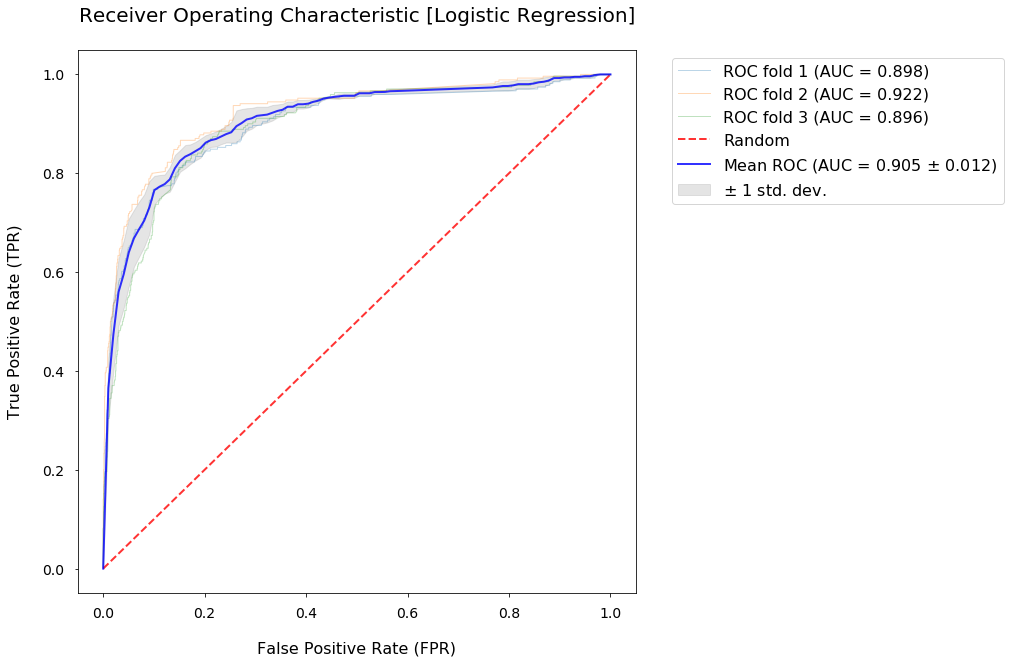

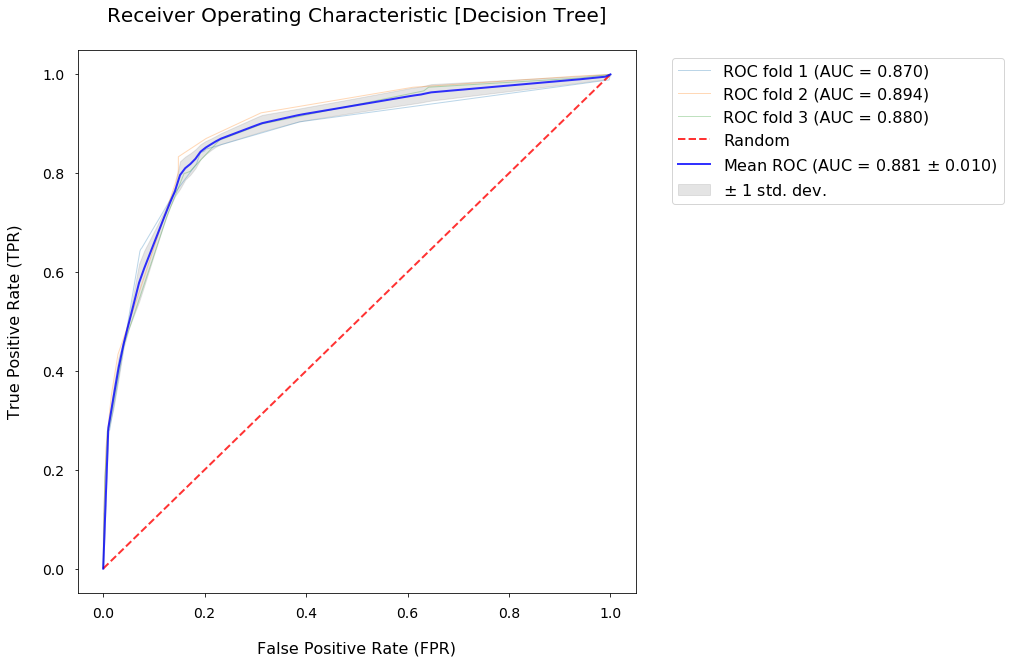

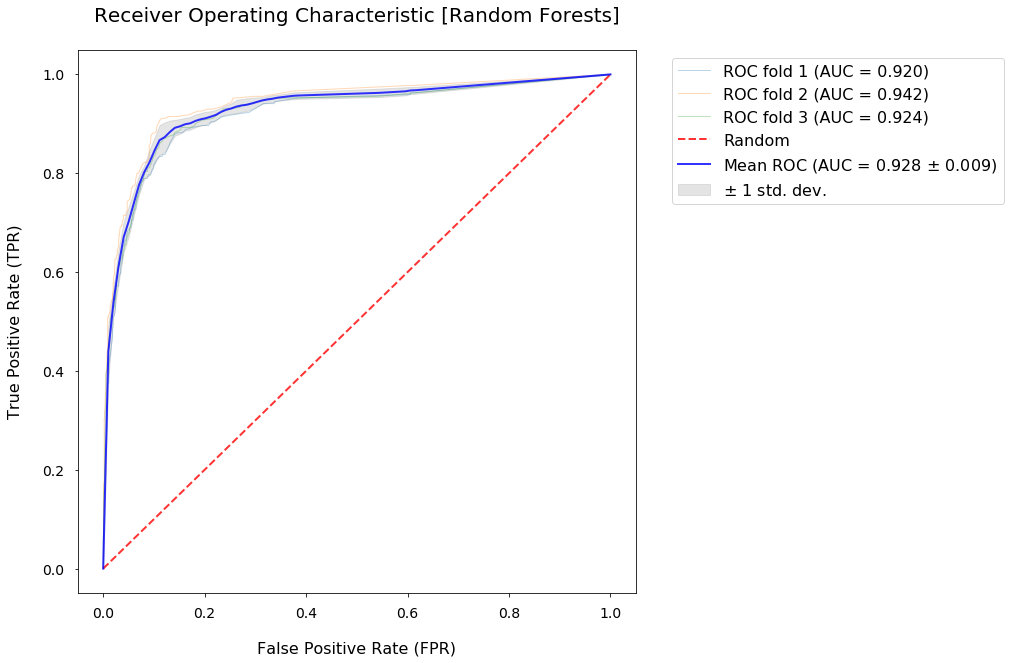

In [325]:
model_comparator.nested_cross_validation(X_train, y_train, features)

In [ ]:
model_comparator.nested_cross_validation_report()

In [157]:
model_comparator.fit_best_model_and_hyperparams(X_train, y_train, features)

***** Find the best hyperparameters of the best learning model selected with nested cross validation *****

==> Retrieve the best model along with its nested cross validation score...
Best Learning Model = [RandomForestClassifier]
Best Learning Model Unbiased roc_auc Estimate = [0.9301812168233985]

==> Create the pipeline to be executed within the cross validation loop


==> Performing Grid Search Cross Validation for Hyperparameter Selection (Inner CV)...

==> Fitting again the best model to the whole dataset (training set)...
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   21.3s finished



==> Storing best performing settings of the best learning model [RandomForestClassifier]


In [ ]:
model_comparator.plot_learning_curve_best()
plt.show()

In [158]:
model_comparator.best_model_report()

,scorer,best_model_name,best_model_hyperparams,best_model_score,n_features,best_feature_names
0,roc_auc,RandomForestClassifier,"{""estimator__n_estimators"": 100, ""selector__k""...",0.932328,45,"numOfParams,numOfBools,numOfIds,numOfBlobs,req..."


In [159]:
model_comparator.evaluate_best(X_test, y_test)

* The cross-validation score (roc_auc) obtained by RandomForestClassifier with this hyperparameter setting is the best         among all the other cross-validation scores for this model grid search, and it evaluates to 0.932


             precision    recall  f1-score   support

         -1       0.94      0.97      0.95       493
          1       0.79      0.67      0.72        90

avg / total       0.92      0.92      0.92       583

Area Under the ROC = [0.924]



In [ ]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np

# `outer_cv` creates 3 folds for estimating generalization error
outer_cv = KFold(3)

# when we train on a certain fold, we use a second cross-validation
# split in order to choose hyperparameters
inner_cv = KFold(3)

# create some regression data
X, y = make_regression(n_samples=1000, n_features=10)

# give shorthand names to models and use those as dictionary keys mapping
# to models and parameter grids for that model
models_and_parameters = {
    'svr': (SVR(),
            {'C': [0.01, 0.05, 0.1, 1]}),
    'rf': (RandomForestRegressor(),
           {'max_depth': [5, 10, 50, 100, 200, 500]})}

# we will collect the average of the scores on the 3 outer folds in this dictionary
# with keys given by the names of the models in `models_and_parameters`
average_scores_across_outer_folds_for_each_model = dict()

# find the model with the best generalization error
for name, (model, params) in models_and_parameters.items():
    # this object is a regressor that also happens to choose
    # its hyperparameters automatically using `inner_cv`
    regressor_that_optimizes_its_hyperparams = GridSearchCV(
        estimator=model, param_grid=params,
        cv=inner_cv, scoring='neg_mean_squared_error')

    # estimate generalization error on the 3-fold splits of the data
    scores_across_outer_folds = cross_val_score(
        regressor_that_optimizes_its_hyperparams,
        X, y, cv=outer_cv, scoring='neg_mean_squared_error')

    # get the mean MSE across each of outer_cv's 3 folds
    average_scores_across_outer_folds_for_each_model[name] = np.mean(scores_across_outer_folds)
    error_summary = 'Model: {name}\nMSE in the 3 outer folds: {scores}.\nAverage error: {avg}'
    print(error_summary.format(
        name=name, scores=scores_across_outer_folds,
        avg=np.mean(scores_across_outer_folds)))
    print()

print('Average score across the outer folds: ',
      average_scores_across_outer_folds_for_each_model)

many_stars = '\n' + '*' * 100 + '\n'
print(many_stars + 'Now we choose the best model and refit on the whole dataset' + many_stars)

best_model_name, best_model_avg_score = max(
    average_scores_across_outer_folds_for_each_model.items(),
    key=(lambda name_averagescore: name_averagescore[1]))

# get the best model and its associated parameter grid
best_model, best_model_params = models_and_parameters[best_model_name]

# now we refit this best model on the whole dataset so that we can start
# making predictions on other data, and now we have a reliable estimate of
# this model's generalization error and we are confident this is the best model
# among the ones we have tried
final_regressor = GridSearchCV(best_model, best_model_params, cv=inner_cv)
final_regressor.fit(X, y)

print('Best model: \n\t{}'.format(best_model), end='\n\n')
print('Estimation of its generalization error (negative mean squared error):\n\t{}'.format(
    best_model_avg_score), end='\n\n')
print('Best parameter choice for this model: \n\t{params}'
      '\n(according to cross-validation `{cv}` on the whole dataset).'.format(
      params=final_regressor.best_params_, cv=inner_cv))

## Feature Importance with RF

In [57]:
# Load the trained model back
rf_model = joblib.load("out/models/randomforestclassifier.pkl")

49
49
Feature ranking:


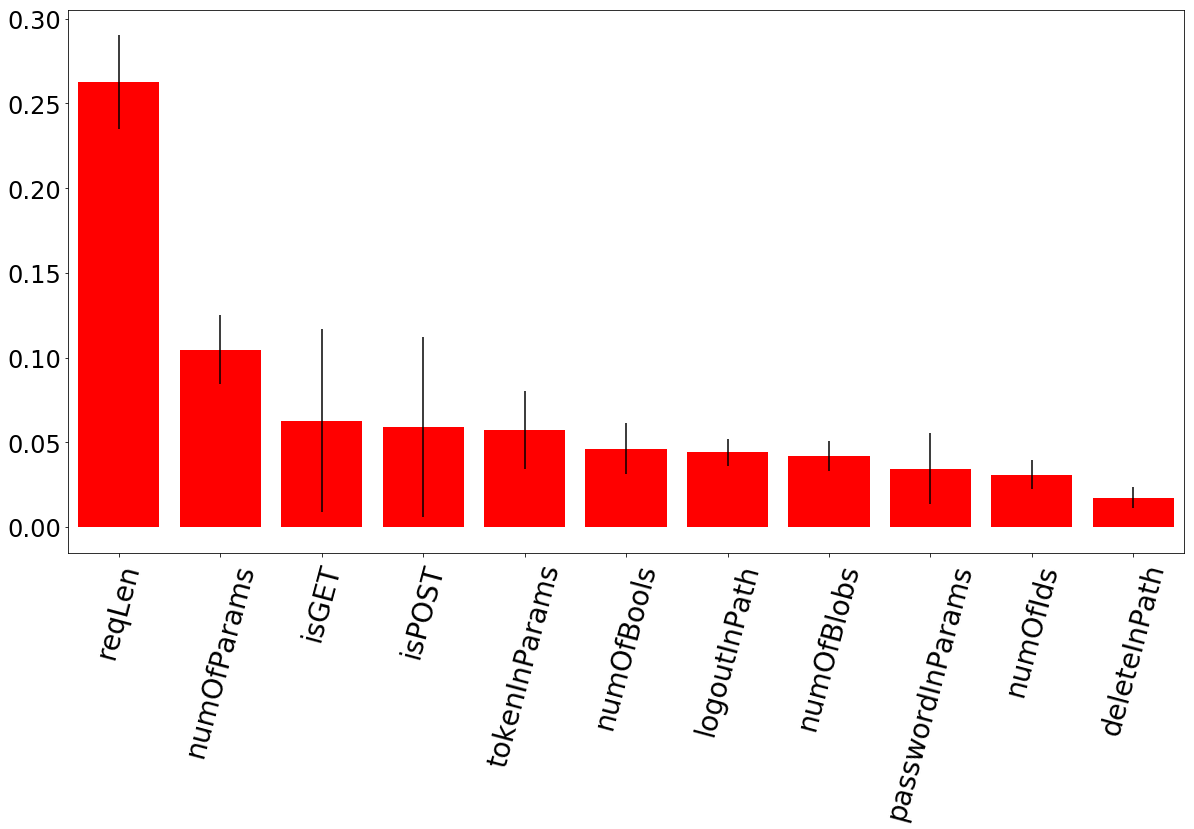

In [106]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print(len(importances))
print(len(indices))

# Print the feature ranking
print("Feature ranking:")
feature_names = data.iloc[:,1:-1].columns.values


# feature_set = set(feature_names)
# feature_set = feature_set - set(['changeInParams'])
# feature_set = feature_set - set(['passwordInPath'])
# feature_set = feature_set - set(['payInPath'])
# feature_set = feature_set - set(['viewInParams'])
# feature_names = list(feature_set)


# for feature_id, feature_name in enumerate(feature_names):
#     print("{}. feature {} ({}) [rank score = {:.3f}]".format(feature_id + 1, 
#                                                        indices[feature_id], 
#                                                        feature_names[indices[feature_id]], 
#                                                        importances[indices[feature_id]]))

#Plot the feature importances of the forest
plt.figure(figsize=(20,10))
#plt.title("Feature importances")
plt.bar(range(len(feature_names)), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(len(feature_names)), feature_names[indices], rotation=75, size=28)
plt.yticks(fontsize=24)
plt.xlim([-.5, 10.5])
plt.show()

Feature ranking:


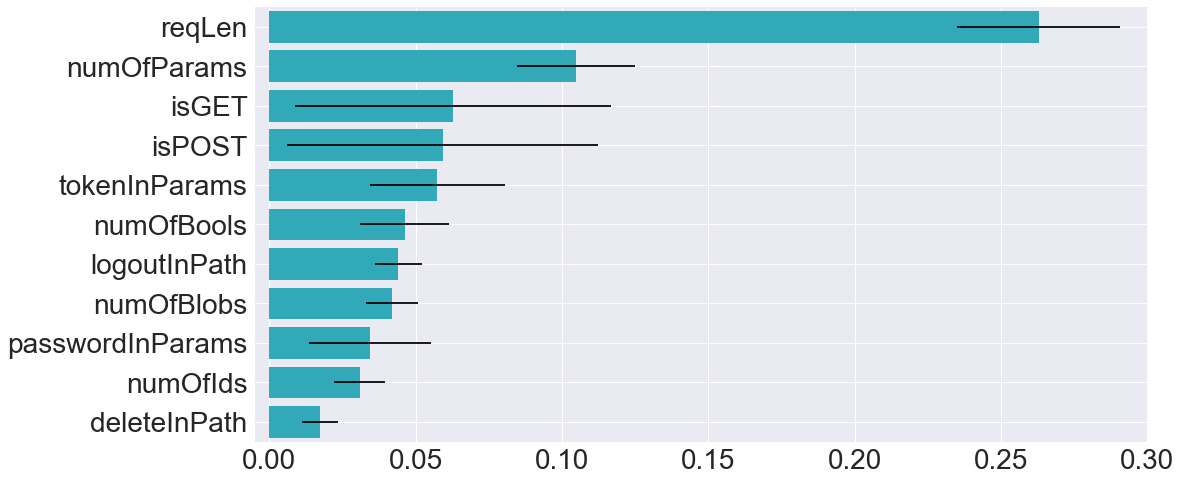

In [119]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


# Print the feature ranking
print("Feature ranking:")
feature_names = data.iloc[:,1:-1].columns.values

# for feature_id, feature_name in enumerate(feature_names):
#     print("{}. feature {} ({}) [rank score = {:.3f}]".format(feature_id + 1, 
#                                                        indices[feature_id], 
#                                                        feature_names[indices[feature_id]], 
#                                                        importances[indices[feature_id]]))

#Plot the feature importances of the forest
fig, ax = plt.subplots(figsize=(16,8))

#ax.set_title("Feature importances")
ax.barh(range(len(feature_names)), importances[indices],
        color="#31a9b8", xerr=std[indices], align="center")
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(feature_names[indices], size=28)
ax.set_ylim([-.5, 10.5])
ax.set_xlim([-0.005, 0.30])
#plt.set_yticks(range(len(feature_names)))
#plt.set_yticklabels(feature_names)
ax.invert_yaxis()  # labels read top-to-bottom
plt.xticks(fontsize=28)
plt.show()

# # Example data
# people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
# y_pos = np.arange(len(people))
# performance = 3 + 10 * np.random.rand(len(people))
# error = np.random.rand(len(people))

# ax.barh(y_pos, performance, xerr=error, align='center',
#         color='green', ecolor='black')
# ax.set_yticks(y_pos)
# ax.set_yticklabels(people)
# ax.invert_yaxis()  # labels read top-to-bottom
# ax.set_xlabel('Performance')
# ax.set_title('How fast do you want to go today?')


In [ ]:
l = ['outer_fold_1_score, outer_fold_1_best_params, outer_fold_1_n_features, outer_fold_1_best_features', 
     'outer_fold_2_score, outer_fold_2_best_params, outer_fold_2_n_features, outer_fold_2_best_features', 
     'outer_fold_3_score, outer_fold_3_best_params, outer_fold_3_n_features, outer_fold_3_best_features', 
     'outer_fold_4_score, outer_fold_4_best_params, outer_fold_4_n_features, outer_fold_4_best_features', 
     'outer_fold_5_score, outer_fold_5_best_params, outer_fold_5_n_features, outer_fold_5_best_features', 
     'outer_fold_6_score, outer_fold_6_best_params, outer_fold_6_n_features, outer_fold_6_best_features', 
     'outer_fold_7_score, outer_fold_7_best_params, outer_fold_7_n_features, outer_fold_7_best_features', 
     'outer_fold_8_score, outer_fold_8_best_params, outer_fold_8_n_features, outer_fold_8_best_features', 
     'outer_fold_9_score, outer_fold_9_best_params, outer_fold_9_n_features, outer_fold_9_best_features', 
     'outer_fold_10_score, outer_fold_10_best_params, outer_fold_10_n_features, outer_fold_10_best_features']

In [ ]:
new_l = [x.split(', ') for x in l]
flat_list = [item for sublist in new_l for item in sublist]
flat_list